# Tutorial 3: Parameter Uncertainty

**Learning Objectives:**
- Go from optimisation to uncertainty quantification
- Use MCMC sampling to explore parameter distributions
- Interpret MCMC diagnostics and traces
- Calculate confidence intervals

## Introduction

Optimisation gives us a **single best** parameter estimate. But how **certain** are we about these values?

MCMC (Markov Chain Monte Carlo) sampling explores the full **posterior distribution**, letting us:
- Quantify parameter uncertainty
- Calculate confidence intervals
- Detect parameter correlations
- Make probabilistic predictions

We'll use a bouncy ball physics model as our example.

In [ ]:
# Import plotting utilities
import diffid
import matplotlib.pyplot as plt
import numpy as np
from diffid.plotting import parameter_distributions, parameter_traces

np.random.seed(42)  # For reproducibility

## The Physics Problem: Falling Ball

A ball falls from height $h$ with gravitational acceleration $g$:

$$\begin{aligned}
\frac{dx}{dt} &= v \\
\frac{dv}{dt} &= -g
\end{aligned}$$

where:
- $x$ is height
- $v$ is velocity  
- $g$ is gravitational acceleration (Earth: ~9.81 m/s²)
- $h$ is initial height

**Task**: Estimate $g$ and $h$ from noisy observations.

## Generate Synthetic Data

In [ ]:
def ball_states(t, g, h):
    """Analytical solution for ball trajectory."""
    height = h - 0.5 * g * t**2
    height = np.maximum(height, 0.0)  # Can't go below ground
    velocity = -g * t
    return height, velocity


# True parameters
g_true = 9.81  # m/s²
h_true = 10.0  # meters

# Time to hit ground: t = sqrt(2h/g)
t_stop = np.sqrt(2.0 * h_true / g_true)
t_final = 0.7 * t_stop  # Stop before hitting ground
t_span = np.linspace(0.0, t_final, 61)

# Generate clean data
height, velocity = ball_states(t_span, g_true, h_true)

# Add measurement noise
noise_std = 0.1
height_noisy = height + np.random.normal(0, noise_std, len(t_span))
velocity_noisy = velocity + np.random.normal(0, noise_std, len(t_span))

# Format for Diffid: [time, height, velocity]
data = np.column_stack((t_span, height_noisy, velocity_noisy))

print(f"Generated {len(t_span)} observations")
print(f"Time span: [0, {t_final:.3f}] seconds")
print(f"Noise level: σ = {noise_std}")
print("\nTrue parameters:")
print(f"  g = {g_true} m/s²")
print(f"  h = {h_true} m")

## Visualize the Data

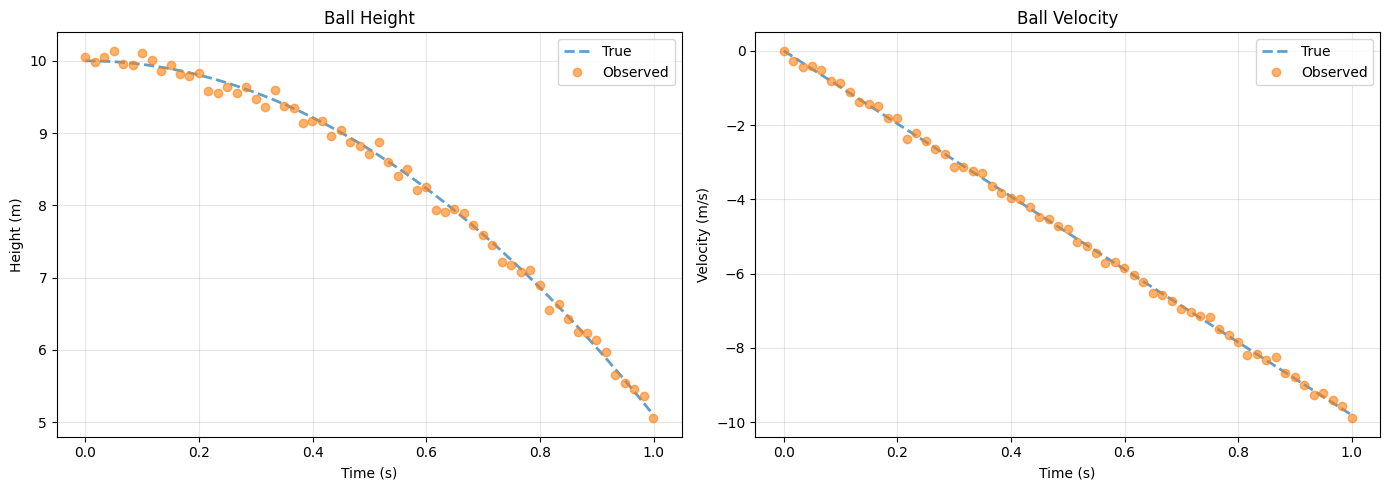

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Height
axes[0].plot(t_span, height, "--", label="True", linewidth=2, alpha=0.7)
axes[0].plot(t_span, height_noisy, "o", label="Observed", alpha=0.6)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Height (m)")
axes[0].set_title("Ball Height")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Velocity
axes[1].plot(t_span, velocity, "--", label="True", linewidth=2, alpha=0.7)
axes[1].plot(t_span, velocity_noisy, "o", label="Observed", alpha=0.6)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Velocity (m/s)")
axes[1].set_title("Ball Velocity")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Define the ODE Model

In [4]:
# DiffSL model for falling ball
dsl_model = """
in_i {g = 1, h = 1 }
u_i {x = h, v = 0}
F_i {v, -g}
stop {x}
"""

print("DiffSL Model:")
print(dsl_model)
print("\nExplanation:")
print("  x = height, v = velocity")
print("  dx/dt = v (velocity determines height change)")
print("  dv/dt = -g (gravity accelerates downward)")
print("  stop {x} (terminate when height reaches zero)")

DiffSL Model:

in_i { g = 1, h = 1 }
u_i {x = h, v = 0}
F_i {v, -g}
stop {x}


Explanation:
  x = height, v = velocity
  dx/dt = v (velocity determines height change)
  dv/dt = -g (gravity accelerates downward)
  stop {x} (terminate when height reaches zero)


## Step 1: Optimisation

First, find the maximum a posteriori (MAP) estimate:

In [ ]:
# Build problem
builder = (
    diffid.DiffsolBuilder()
    .with_diffsl(dsl_model)
    .with_data(data)
    .with_parameter("g", 5.0)  # Initial guess
    .with_parameter("h", 5.0)  # Initial guess
    .with_cost(diffid.RMSE(2.0))  # 2 observables (height + velocity)
)

problem = builder.build()

# Optimize
optimiser = diffid.Adam().with_step_size(0.05).with_max_iter(1500)
opt_result = optimiser.run(problem, [5.0, 5.0])

print("\n" + "=" * 60)
print("OPTIMIZATION RESULTS (MAP Estimate)")
print("=" * 60)
print(f"Success: {opt_result.success}")
print("\nFitted parameters:")
print(f"  g = {opt_result.x[0]:.4f} m/s²  (true: {g_true})")
print(f"  h = {opt_result.x[1]:.4f} m     (true: {h_true})")
print(f"\nCost: {opt_result.value:.6f}")
print(f"Iterations: {opt_result.iterations}")

g_map, h_map = opt_result.x

## Step 2: MCMC Sampling

Now explore the full posterior distribution:

In [ ]:
# Rebuild problem with GaussianNLL (required for sampling)
builder_sampling = (
    diffid.DiffsolBuilder()
    .with_diffsl(dsl_model)
    .with_data(data)
    .with_parameter("g", g_map)  # Start from MAP
    .with_parameter("h", h_map)
    # .with_parallel(True)
    .with_cost(diffid.GaussianNLL(variance=noise_std**2))
)

problem_sampling = builder_sampling.build()

# Setup MCMC sampler
sampler = (
    diffid.MetropolisHastings()
    .with_num_chains(10)
    .with_iterations(1000)
    .with_step_size(0.035)
)

print("\n" + "=" * 60)
print("MCMC SAMPLING")
print("=" * 60)
print(f"\nStarting from MAP estimate: g = {g_map:.4f}, h = {h_map:.4f}")
print("\nRunning MCMC... (this may take a minute)")

# Run sampling
mcmc_result = sampler.run(problem_sampling, [g_map, h_map])

print("\nSampling complete!")
print(f"Samples shape: {mcmc_result.samples.shape}")
print(f"Acceptance rate: {mcmc_result.acceptance_rate}")
print("Target acceptance: 0.20 - 0.40")

if np.any(mcmc_result.acceptance_rate < 0.15) or np.any(
    mcmc_result.acceptance_rate > 0.50
):
    print("⚠️  Warning: Acceptance rate is outside optimal range")
    print("   Consider adjusting step_size")
else:
    print("✓ Acceptance rate looks good!")

## Analyze MCMC Results

### Parameter Traces

Trace plots show how parameters evolved during sampling:

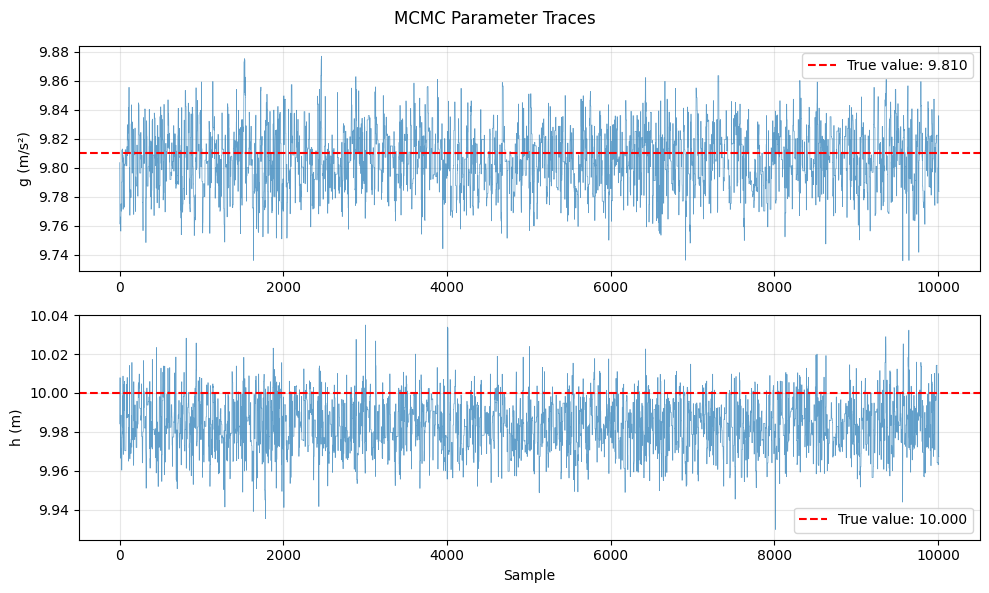


What to look for in traces:
  - Good mixing (wiggly, no trends)
  - Stationary (mean stays constant)
  - No long excursions
  - Rapid exploration of parameter space


In [7]:
# Plot traces
fig, axes = parameter_traces(
    mcmc_result.samples,
    param_names=["g (m/s²)", "h (m)"],
    true_values=[g_true, h_true],
    show=False,
)

plt.show()

print("\nWhat to look for in traces:")
print("  - Good mixing (wiggly, no trends)")
print("  - Stationary (mean stays constant)")
print("  - No long excursions")
print("  - Rapid exploration of parameter space")

### Parameter Distributions

Histograms show the posterior distribution:

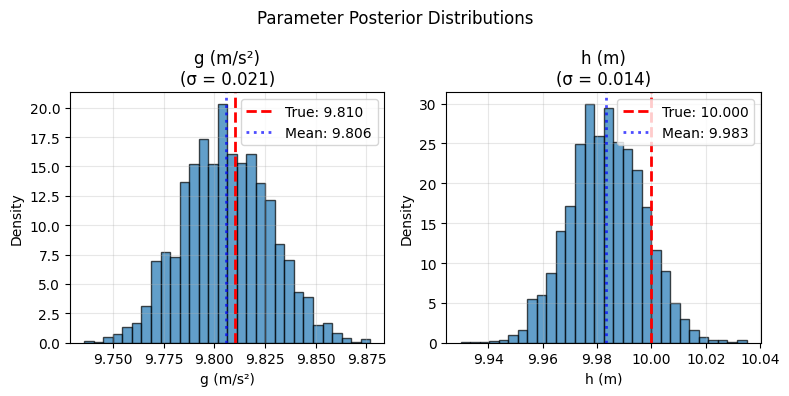

In [8]:
# Plot distributions
fig, axes = parameter_distributions(
    mcmc_result.samples,
    param_names=["g (m/s²)", "h (m)"],
    true_values=[g_true, h_true],
    show=False,
)

plt.show()

## Calculate Statistics

In [9]:
# Burn-in: discard first 20% of samples
burn_in = int(0.2 * len(mcmc_result.samples))
samples_burned = mcmc_result.samples[burn_in:]

# Calculate statistics
g_samples = samples_burned[:, 0]
h_samples = samples_burned[:, 1]

# Means and standard deviations
g_mean = np.mean(g_samples)
g_std = np.std(g_samples)
h_mean = np.mean(h_samples)
h_std = np.std(h_samples)

# 95% credible intervals
g_ci = np.percentile(g_samples, [2.5, 97.5])
h_ci = np.percentile(h_samples, [2.5, 97.5])

print("\n" + "=" * 60)
print("POSTERIOR STATISTICS (after burn-in)")
print("=" * 60)
print(f"Samples used: {len(samples_burned):,}")
print("\nGravitational acceleration (g):")
print(f"  True value:  {g_true:.4f} m/s²")
print(f"  MAP:         {g_map:.4f} m/s²")
print(f"  Posterior:   {g_mean:.4f} ± {g_std:.4f} m/s²")
print(f"  95% CI:      [{g_ci[0]:.4f}, {g_ci[1]:.4f}]")
print("\nInitial height (h):")
print(f"  True value:  {h_true:.4f} m")
print(f"  MAP:         {h_map:.4f} m")
print(f"  Posterior:   {h_mean:.4f} ± {h_std:.4f} m")
print(f"  95% CI:      [{h_ci[0]:.4f}, {h_ci[1]:.4f}]")

# Check if true values are in credible intervals
g_in_ci = g_ci[0] <= g_true <= g_ci[1]
h_in_ci = h_ci[0] <= h_true <= h_ci[1]

print("\nTrue values in 95% CI:")
print(f"  g: {'✓' if g_in_ci else '✗'}")
print(f"  h: {'✓' if h_in_ci else '✗'}")


POSTERIOR STATISTICS (after burn-in)
Samples used: 8,008

Gravitational acceleration (g):
  True value:  9.8100 m/s²
  MAP:         9.8035 m/s²
  Posterior:   9.8061 ± 0.0210 m/s²
  95% CI:      [9.7679, 9.8473]

Initial height (h):
  True value:  10.0000 m
  MAP:         9.9841 m
  Posterior:   9.9834 ± 0.0134 m
  95% CI:      [9.9569, 10.0096]

True values in 95% CI:
  g: ✓
  h: ✓


## Parameter Correlations

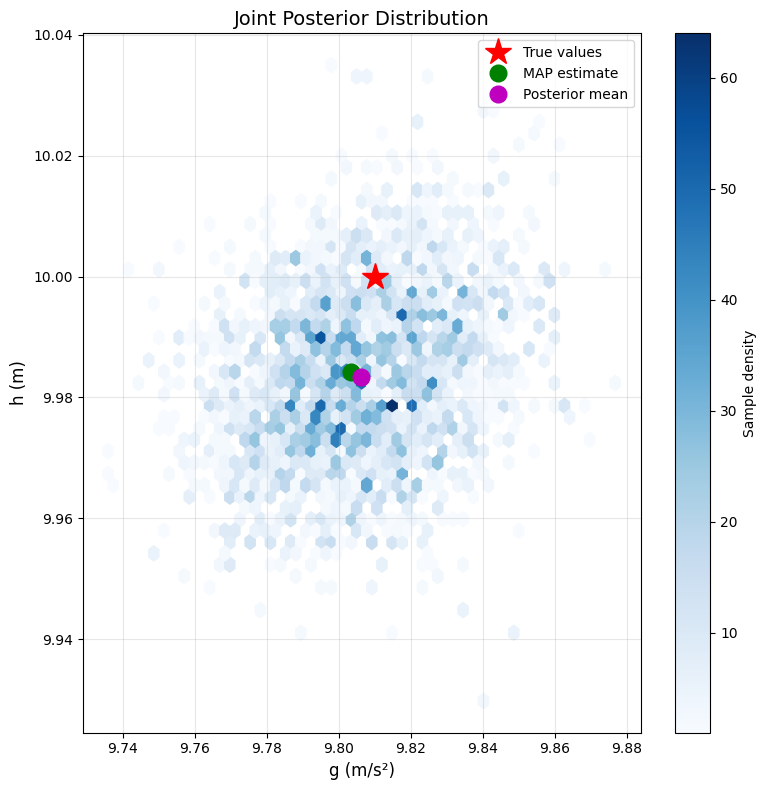


Parameter correlation: 0.2667
  Low correlation - parameters are nearly independent


In [10]:
# Scatter plot of joint distribution
fig, ax = plt.subplots(figsize=(8, 8))

# Hexbin plot for large sample sizes
hb = ax.hexbin(g_samples, h_samples, gridsize=50, cmap="Blues", mincnt=1)
ax.plot(g_true, h_true, "r*", markersize=20, label="True values", zorder=5)
ax.plot(g_map, h_map, "go", markersize=12, label="MAP estimate", zorder=5)
ax.plot(g_mean, h_mean, "mo", markersize=12, label="Posterior mean", zorder=5)

ax.set_xlabel("g (m/s²)", fontsize=12)
ax.set_ylabel("h (m)", fontsize=12)
ax.set_title("Joint Posterior Distribution", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.colorbar(hb, ax=ax, label="Sample density")
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = np.corrcoef(g_samples, h_samples)[0, 1]
print(f"\nParameter correlation: {correlation:.4f}")

if abs(correlation) > 0.7:
    print("  High correlation - parameters are not independently identifiable")
elif abs(correlation) > 0.3:
    print("  Moderate correlation")
else:
    print("  Low correlation - parameters are nearly independent")

## Posterior Predictive Distribution

Use samples to make probabilistic predictions:

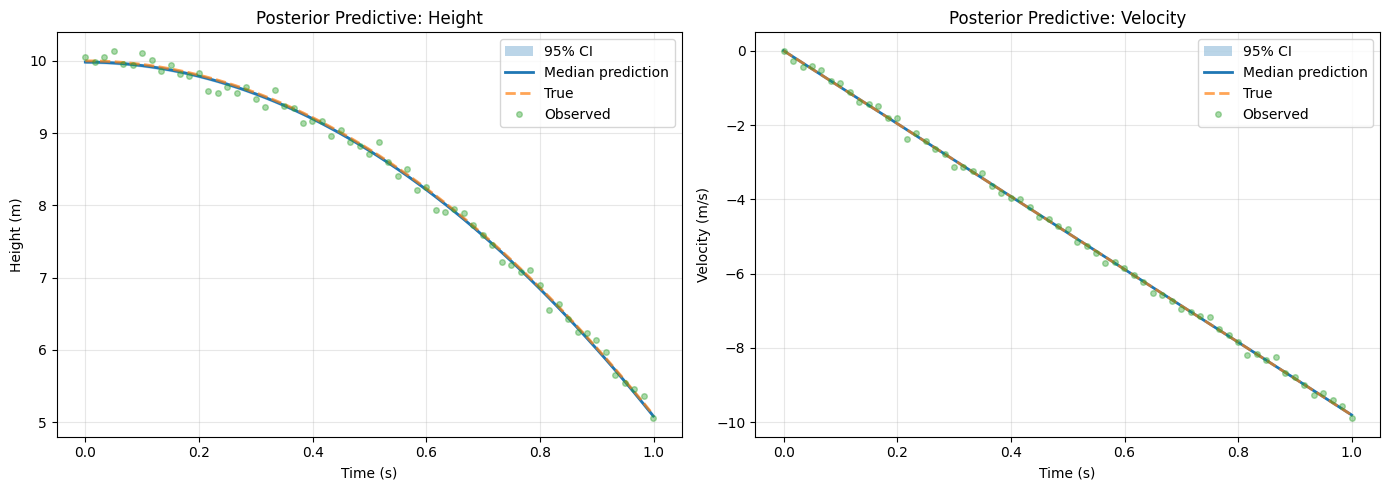

The shaded region shows the 95% credible interval for predictions
This accounts for both parameter uncertainty and observation noise


In [11]:
# Take random subset of samples for predictions
n_pred_samples = 200
sample_indices = np.random.choice(len(samples_burned), n_pred_samples, replace=False)

# Generate predictions for each sample
predictions_height = []
predictions_velocity = []

for idx in sample_indices:
    g_sample, h_sample = samples_burned[idx]
    h_pred, v_pred = ball_states(t_span, g_sample, h_sample)
    predictions_height.append(h_pred)
    predictions_velocity.append(v_pred)

predictions_height = np.array(predictions_height)
predictions_velocity = np.array(predictions_velocity)

# Calculate percentiles
h_median = np.median(predictions_height, axis=0)
h_lower = np.percentile(predictions_height, 2.5, axis=0)
h_upper = np.percentile(predictions_height, 97.5, axis=0)

v_median = np.median(predictions_velocity, axis=0)
v_lower = np.percentile(predictions_velocity, 2.5, axis=0)
v_upper = np.percentile(predictions_velocity, 97.5, axis=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Height
axes[0].fill_between(t_span, h_lower, h_upper, alpha=0.3, label="95% CI")
axes[0].plot(t_span, h_median, "-", linewidth=2, label="Median prediction")
axes[0].plot(t_span, height, "--", linewidth=2, label="True", alpha=0.7)
axes[0].plot(t_span, height_noisy, "o", label="Observed", alpha=0.4, markersize=4)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Height (m)")
axes[0].set_title("Posterior Predictive: Height")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Velocity
axes[1].fill_between(t_span, v_lower, v_upper, alpha=0.3, label="95% CI")
axes[1].plot(t_span, v_median, "-", linewidth=2, label="Median prediction")
axes[1].plot(t_span, velocity, "--", linewidth=2, label="True", alpha=0.7)
axes[1].plot(t_span, velocity_noisy, "o", label="Observed", alpha=0.4, markersize=4)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Velocity (m/s)")
axes[1].set_title("Posterior Predictive: Velocity")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The shaded region shows the 95% credible interval for predictions")
print("This accounts for both parameter uncertainty and observation noise")

## Key Takeaways

1. **Optimisation** gives point estimates; **MCMC** quantifies uncertainty
2. **GaussianNLL** cost metric is required for sampling
3. **Acceptance rate** should be 20-40% for efficient exploration
4. **Burn-in** period discards initial non-stationary samples
5. **Credible intervals** provide uncertainty bounds
6. **Posterior predictive** distributions account for parameter uncertainty

## MCMC Diagnostics Checklist

✓ Acceptance rate in [0.2, 0.4]  
✓ Trace plots show good mixing  
✓ No trends in traces  
✓ Distributions look reasonable  
✓ True values in credible intervals  

## Next Steps

- [Tutorial 4: Model Comparison](04_model_comparison.ipynb) - Use nested sampling for Bayes factors
- [Choosing a Sampler](../../guides/choosing-sampler.md) - MCMC vs Nested Sampling
- [API Reference: Samplers](../../api-reference/python/samplers.md)

## Exercises

1. **Step Size**: Try different `step_size` values (0.1, 0.5, 1.0) and observe acceptance rates

2. **More Data**: Increase the number of observations and see how uncertainty decreases

3. **More Noise**: Increase `noise_std` to 0.5 and observe wider credible intervals

4. **Longer Chains**: Run with 10,000 iterations per chain for better convergence